<a href="https://colab.research.google.com/github/cullena20/RedditSentiment/blob/main/RedditSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reddit Sentiment Analysis!

In [1]:
from IPython import display  # control displaying of printed output in loops
import math
from pprint import pprint  # pretty print json and lists
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
!pip install praw
import praw

     |████████████████████████████████| 153kB 6.1MB/s 
     |████████████████████████████████| 204kB 20.5MB/s 


In [14]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Exploring the Reddit API using PRAW

Access the Reddit API. To do this go to https://www.reddit.com/prefs/apps/

In [2]:
reddit = praw.Reddit(client_id='etCTL0OgGAY1jA',
                     client_secret='vMtYIGE5WVK8BDczKh7ZnRup3rb3ew',
                     user_agent='Conscious-Reply-7037',
                     username='Conscious-Reply-7037')

In [15]:
# subreddit1 = reddit.subreddits.search_by_name('datascience', exact=True)  returns a list of search results
subreddit = reddit.subreddit('datascience')
print("Display Name:")
print(subreddit.display_name) 
print()
print("Title:")
print(subreddit.title)   
print()
print("Description")      
print(subreddit.description) 

Display Name:
datascience

Title:
Data Science

Description



In [18]:
posts = set()  # use a set to clear any duplicates
for post in subreddit.new(limit=None):
  posts.add(post)
  display.clear_output()  # only one output that changes
  print(len(posts))
posts = list(posts)  # easier to work with lists

735


In [19]:
post = posts[2]
print(post.title)
print(post.author)
print(post.score)
print(post.id)
print(post.url)

How do I learn more about data cleaning \ wrangling?
Old_H00nter
255
jlhqq4
https://www.reddit.com/r/datascience/comments/jlhqq4/how_do_i_learn_more_about_data_cleaning_wrangling/


## Some Text Preprocessing (unecessary for now)


Preprocess the data by tokenizing it. This is unecessary with the vader model that we are using.

We will first use word_tokenize from nltk.

In [71]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')  # needed for word_tokenize
nltk.download('stopwords')

stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Another method to split up article into sentences and them average the positive and negative scores.

In [72]:
from nltk.tokenize import sent_tokenize, word_tokenize
article = "Google staff awoke on Wednesday to surprising news: Their company is working on a search app tailored, and censored, for China. The project, kept secret from all but select teams and leaders, sparked a furious internal debate. Yet the move couldn’t have been entirely surprising for Googlers."
article_tokenized = sent_tokenize(article)

print(article_tokenized)
neg_scores = []
pos_scores = []
for i in article_tokenized:
    print(sia.polarity_scores(i))
    neg_scores.append(sia.polarity_scores(i)['neg'])
    pos_scores.append(sia.polarity_scores(i)['pos'])

['Google staff awoke on Wednesday to surprising news: Their company is working on a search app tailored, and censored, for China.', 'The project, kept secret from all but select teams and leaders, sparked a furious internal debate.', 'Yet the move couldn’t have been entirely surprising for Googlers.']
{'neg': 0.074, 'neu': 0.829, 'pos': 0.097, 'compound': 0.128}
{'neg': 0.265, 'neu': 0.735, 'pos': 0.0, 'compound': -0.7227}
{'neg': 0.0, 'neu': 0.79, 'pos': 0.21, 'compound': 0.3384}


I found this code on Github. Let's try it out.
Update: word_tokenize works better

In [73]:
# !pip install git+https://github.com/erikavaris/tokenizer.git
# from tokenizer import tokenizer
# R = tokenizer.RedditTokenizer()

In [74]:
sentence = "yo whats up /u/MrJones?! Check out r/spacedicks!"
print(word_tokenize(sentence))
# print(R.tokenize(sentence))

['yo', 'whats', 'up', '/u/MrJones', '?', '!', 'Check', 'out', 'r/spacedicks', '!']


## Basic Sentiment Analysis Using Pretrained Models


For now, we will explore various pretrained models that detect negative and positive sentiment. Alternativley, we could train our own model using a dataset and sklearn. However, this will do for now.

Code for other models is commented out because we are not using them. You can uncomment to explore them though.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
# from textblob import TextBlob
# !pip install flair
# import flair
# flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

In [21]:
sentence = "This food was great but the service was only okay"
print("NLTK VADER")
print(sia.polarity_scores(sentence))
# print()
# print("Text Blob:")
# print(TextBlob(sentence).sentiment)
# print()
# print("Flair:")
# s = flair.data.Sentence(sentence)
# flair_sentiment.predict(s)
# total_sentiment = s.labels
# print(total_sentiment)

NLTK VADER
{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.5994}

Text Blob:
Sentiment(polarity=0.43333333333333335, subjectivity=0.75)

Flair:
[POSITIVE (0.5546)]


In [44]:
results = list()

for post in posts:
    pol_score = sia.polarity_scores(post.title)
    pol_score['headline'] = post.title
    results.append(pol_score)

pprint(results[732], width=100)  # pretty print

{'compound': 0.4019,
 'headline': 'Any interesting data science/deep learning/machine learning journals?',
 'neg': 0.0,
 'neu': 0.69,
 'pos': 0.31}


Now we will store the data as a pandas dataframe. 

In [78]:
df = pd.DataFrame.from_records(results)
df['label'] = 0  # creates label column
df.loc[df['compound'] > 0.2, 'label'] = 1  # if compound score is greater than 0.2 we label it as positive
df.loc[df['compound'] < -0.2, 'label'] = -1  # if compound score is less than -0.2 we label it as positive
df.sample(n=10,axis='rows')  # prints 10 random items from the dataframe

,neg,neu,pos,compound,headline,label
628,0.14,0.558,0.302,0.3612,"Really Stumped With This Question - Feeling Helpless, Could Someone Please Try to Help? (about network graphs)",1
675,0.00,1.000,0.000,0.0000,Data science position using SAS,0
18,0.00,1.000,0.000,0.0000,Dummy variables or standardization?,0
52,0.00,1.000,0.000,0.0000,Understanding the Hiring Process (so you can make it work for your),0
591,0.00,1.000,0.000,0.0000,Actuary to Data scientist.,0
61,0.00,0.758,0.242,0.3724,Provocative question: is there a version of R that isn't broken?,1
37,0.00,0.787,0.213,0.2263,Tools for documenting data exploration in code repo,1
510,0.00,0.748,0.252,0.4019,My notebooks repo is a hot mess… can y’all help?,1
484,0.00,1.000,0.000,0.0000,Percentage of non traditional path Data Scientists in your team,0
563,0.00,0.861,0.139,0.6369,What’s the best way to build a forecasting prediction model with many (hundreds to a thousand) of relatively short (like 45 days of daily numeric data) time series data?,1


We can explore the most positive and negative sentiments like so. I am using regex to print the headlines a little nicer which seems messy.

In [79]:
import re
pd.options.display.max_colwidth = 200

sorted_df = df.sort_values(by='compound')
print('Five Most Positive Titles:')
print(re.sub(' +', ' ', sorted_df.tail(5)['headline'].to_string(index=False)))  # seems overly complicated
print()
print('Five Most Negative Titles:')
print(re.sub(' +', ' ', sorted_df.head(5)['headline'].to_string(index=False)))  # seems overly complicated


Five Most Positive Titles:
 As a data scientist, what action should be taken to have the greatest positive impact on society and the environment?
 Why do you love / hate about the Data Science field ? And how it compare to Software Engineering. I'm very appreciated about your sharing. Thank you very much.
 After spending more than a year as a data scientist I found these 4 hard truths data science blogs don't teach you about. I hope sharing my journey helps you in some way.
 [X-Post] Based on feedback during our Q&A Sessions, I've created a LinkedIn group for aspiring Data Scientists/MLEs that you might find useful. I'm hoping it'll act as a tool to gain useful tips a...
 A whole year from now to start applying to DS jobs. I'm in a good situation. I can choose what skills to improve, and I'm sure your advice will be super helpful.

Five Most Negative Titles:
 What was your most WTF analysis or insight obtained?
 Angry rant
 What is the difference between training error and in-sample er

Now that we have our results, we can save them in a csv file!

In [65]:
result_df = df[['headline', 'label']]
result_df.to_csv('reddit_headline_sentiment.csv', mode='a', encoding='UTF-8', index=False)

## Exploring Our Results

This code will print th first five negative results and the first five positive results. These do not take into account how positive or negative that they are.

In [80]:
positive_results = df[df['label'] == 1]
negative_results = df[df['label'] == -1]
print("Postitive Results:")
pprint(list(positive_results['headline'])[:5]) 
print()
print("Negative Results:")
pprint(list(negative_results['headline'])[:5]) 

Postitive Results:
['Best Certificates for Data Science',
 'Project ideas that combines data science with Business Intelligence or '
 'Business Analytics for my thesis',
 't-SNE usefulness',
 'Data Science Degree/Career on the line, please help!',
 'Potential of Artificial Intelligence (AI) in Military']

Negative Results:
['What are the common mistakes aspiring data scientists make?',
 'Is putting data camp certificates on linkedin obnoxious?',
 'Question about aftereffects of predictive modeling during a crisis',
 'Landing a Senior Data Scientist Job After 6 Months of Unemployment',
 'Job scams']


In [81]:
percentages = df.label.value_counts(normalize=True) * 100
print("Count:")
print(df.label.value_counts())
print()
print("Percentages:")
print(percentages)

Count:
 0    458
 1    206
-1     71
Name: label, dtype: int64

Percentages:
 0    62.312925
 1    28.027211
-1     9.659864
Name: label, dtype: float64


[]

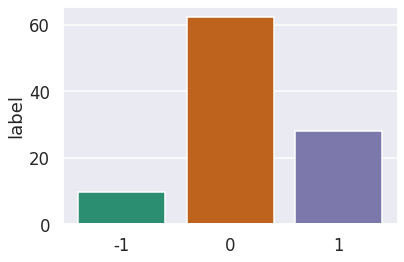

In [82]:
sns.barplot(x=percentages.index, y=percentages)
plt.xlabel = ['Negative', 'Nuetral', 'Positive']
plt.plot()

## More with the Reddit API

Let's take this a bit further and explore comments in posts!

In [89]:
# this creates a list of comments from the post we already defined
comments = list(post.comments)
# pprint(vars(comments[1]))  # gives us variables for comment
print('Post Title:', post.title)
print()
print('Comment: ', comments[1].body)
print()
print('Comment Author: ', comments[1].author)
print('Score: ', comments[1].score)  # would be nice to have model weigh this too

Post Title: Linking Script/Report Output to PPT Presentations - Best Practices?

Comment:  You can add linked objects (tables, graphs, etc) in PPT, which will update their values to match the objects in another file, like Excel.

But then you have to keep the excel updated.

And you have to worry about file paths matching and using network share drives.

You could try automating the population of that excel object, but that's super brittle and to be honest you'd probably spend more hours maintaining that code with all the changes than it would to just keep up with the PowerPoint.

Comment Author:  playawhile
Score:  2


Perhaps we can make a model that gathers sentiment from the comments within a subreddit as well as from the top posts.